In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
import requests
import re

import networkx as nx

import signal

import warnings
warnings.filterwarnings("ignore")

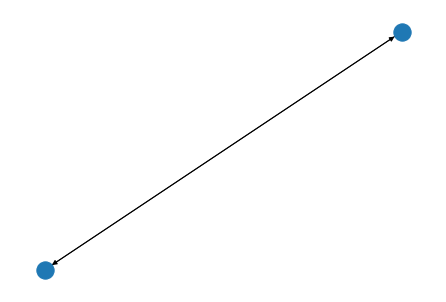

In [47]:
G = nx.MultiDiGraph()
G.add_edges_from([("one", "two"), ("two", "one")])

nx.draw(G)
plt.show()

In [131]:
class GraphCreator:
    
    def __init__(self, entry):
        self.graph = nx.DiGraph()
        
        self.next_links = self.get_article_info(entry)['links']
        self.seen = {entry}
        
        # setup timeout function
        def handle_alarm(signum, frame):
            raise RuntimeError

        signal.signal(signal.SIGALRM, handle_alarm)
        
    def has_key(self, key, resp, pageid):
        return bool(resp['query']["pages"][pageid].get(key))
    
    def add_edges(self, article_info):
        self.graph.add_edges_from([(article_info['title'], link) for link in article_info['links']])
        self.graph.add_edges_from([(linkhere, article_info['title']) for linkhere in article_info['linkshere']])
        
    def plot_graph(self):
        nx.draw(self.graph)
        plt.show()
    
    def get_degrees(self):
        return sorted([(key, val) for key, val in dict(self.graph.degree()).items()], key=lambda x: x[1], reverse=True)
    
    def get_centrality(self):
        return sorted([(key, val) for key, val in dict(nx.eigenvector_centrality(self.graph)).items()], key=lambda x: x[1], reverse=True)
    
    def expand_network(self):
        num_links = len(self.next_links)
        for i in range(num_links):
            link = self.next_links.pop(0)
            if not link in self.seen:
                try:
                    signal.alarm(5)
                    print(i, link)
                    self.seen.add(link)
                    self.next_links += self.get_article_info(link)
                    signal.alarm(0)
                except:
                    continue
    
    def get_article_info(self, title, generate_graph=True):
        params = {
            "action": "query",
            "format": "json",

            "titles": title,

            "prop": "extracts|redirects|links|linkshere|categories",

            # extracts
            "exintro": True,
            "explaintext": True,
            "exsectionformat": "plain",

            # redirects
            "rdnamespace": 0,
            "rdlimit": "max", 
            
            # links
            "pllimit": "max",
            "plnamespace": 0,

            # linkshere
            "lhlimit": "max",
            "lhnamespace": 0,
            "lhshow": "!redirect",

            # categories
            "cllimit": "max",
            
            # automatic redirect
            "redirects": 1
        }

        article_id = []
        extract = []
        redirects = []
        links = []
        linkshere = []
        categories = []

        def query_info(title, params):

            resp = requests.get(
                url="https://en.wikipedia.org/w/api.php",
                params=params).json()
            
#             pdb.set_trace()
            
            pageid = list(resp["query"]['pages'].keys())[0]
            
            article_id.append(pageid)
            
            if self.has_key("extract", resp, pageid):
                extract.append(resp['query']["pages"][pageid]['extract'])
            
            if self.has_key("redirects", resp, pageid):
                for rd in resp['query']["pages"][pageid]["redirects"]:
                    redirects.append(rd["title"])
                    
            if self.has_key("links", resp, pageid):
                for link in resp['query']["pages"][pageid]["links"]:
                    links.append(link["title"])

            if self.has_key("linkshere", resp, pageid):
                for lh in resp['query']["pages"][pageid]["linkshere"]:
                    linkshere.append(lh["title"])

            if self.has_key("categories", resp, pageid):
                for cat in resp['query']["pages"][pageid]["categories"]:
                    if not bool(re.findall(r"(articles)|(uses)|(commons)", cat["title"], re.I)):
                        categories.append(cat["title"])

            if resp.get('continue'):
                params.update(resp.get("continue"))
                query_info(title, params)

        query_info(title, params)
        
        article_info = {
            "pageid": int(article_id[0]),
            "title": title,
            "extract": extract,
            "redirects": redirects,
            "links": links,
            "linkshere": linkshere,
            "categories": categories,
        }
        
        if generate_graph:
            self.add_edges(article_info)
        
        return article_info

## TESTS

In [132]:
gc = GraphCreator("Random Forest")
gc.next_links = gc.next_links

In [134]:
gc.expand_network()

0 Annals of Mathematics and Artificial Intelligence
1 Annals of Statistics
2 Anomaly detection
3 ArXiv
4 Artificial neural network
5 Artificial neural networks
6 Association rule learning
7 Autoencoder
8 Automated machine learning
9 BIRCH
10 Bayesian network
11 Bias–variance dilemma
12 Bias–variance tradeoff
13 Boosting (machine learning)
14 Bootstrap aggregating
15 CURE data clustering algorithm
16 Canonical correlation analysis
17 CiteSeerX
18 Classification and regression tree
19 Cluster analysis
20 Computational learning theory
21 Conditional random field
22 Conference on Neural Information Processing Systems
23 Convolutional neural network
24 Correlation
25 Cross-validation (statistics)
26 DBSCAN
27 Data mining
28 Decision tree
29 Decision tree learning
30 DeepDream
31 Deep learning
32 Digital object identifier
33 Dimensionality reduction
34 Donald Geman
35 Empirical risk minimization
36 Ensemble learning
37 Expectation–maximization algorithm
38 Factor analysis
39 Feature (machine

In [135]:
gc.get_centrality()

[('Regression analysis', 0.15701818955988317),
 ('Logistic regression', 0.15087927729348824),
 ('Linear regression', 0.14856783981199823),
 ('Cluster analysis', 0.1482051965488271),
 ('Statistical classification', 0.14813225292464283),
 ('Principal component analysis', 0.14801497677667969),
 ('Graphical model', 0.1447524113591597),
 ('Factor analysis', 0.1443778730619997),
 ('Linear discriminant analysis', 0.14372184110856828),
 ('Canonical correlation analysis', 0.14104120440375578),
 ('Machine learning', 0.11690060353422864),
 ('Data mining', 0.09733029656389819),
 ('Cross-validation (statistics)', 0.0956912666024309),
 ('Artificial neural networks', 0.09212119540348558),
 ('Supervised learning', 0.09125316899238971),
 ('Bayesian network', 0.0901558444745824),
 ('Artificial neural network', 0.09003650574198144),
 ('Unsupervised learning', 0.08979073536060454),
 ('Reinforcement learning', 0.08961503456233012),
 ('Deep learning', 0.08774156882175738),
 ('Hidden Markov model', 0.0876643

In [123]:
gc.seen

{'Annals of Mathematics and Artificial Intelligence',
 'Annals of Statistics',
 'Anomaly detection',
 'ArXiv',
 'Artificial neural network',
 'Artificial neural networks',
 'Association rule learning',
 'Autoencoder',
 'Automated machine learning',
 'BIRCH',
 'Bayesian network',
 'Bias–variance dilemma',
 'Bias–variance tradeoff',
 'Boosting (machine learning)',
 'Bootstrap aggregating',
 'CURE data clustering algorithm',
 'Canonical correlation analysis',
 'CiteSeerX',
 'Classification and regression tree',
 'Cluster analysis',
 'Computational learning theory',
 'Conditional random field',
 'Conference on Neural Information Processing Systems',
 'Convolutional neural network',
 'Correlation',
 'Cross-validation (statistics)',
 'DBSCAN',
 'Data mining',
 'Decision tree',
 'Decision tree learning',
 'Deep learning',
 'DeepDream',
 'Digital object identifier',
 'Dimensionality reduction',
 'Donald Geman',
 'Empirical risk minimization',
 'Ensemble learning',
 'Expectation–maximization al

In [124]:
gc.get_degrees()

[('Mathematical Reviews', 7638),
 ('Wikipedia', 3633),
 ('Machine learning', 2809),
 ('Trademark', 2548),
 ('Glossary of artificial intelligence', 2095),
 ('Regression analysis', 2039),
 ('Data mining', 1732),
 ('Cluster analysis', 1540),
 ('Principal component analysis', 1493),
 ('R (programming language)', 1416),
 ('Linear regression', 1405),
 ('Factor analysis', 1402),
 ('R programming language', 1391),
 ('Outline of machine learning', 1378),
 ('Logistic regression', 1341),
 ('Statistical classification', 1336),
 ('Artificial neural network', 1305),
 ('Artificial neural networks', 1224),
 ('Linear discriminant analysis', 1210),
 ('Graphical model', 1207),
 ('Sampling (statistics)', 1143),
 ('Cross-validation (statistics)', 1052),
 ('Correlation', 1002),
 ('Mode (statistics)', 988),
 ('Canonical correlation analysis', 950),
 ('Deep learning', 926),
 ('Reinforcement learning', 894),
 ('Hidden Markov model', 820),
 ('Supervised learning', 697),
 ('Convolutional neural network', 655),
 